In [2]:
import string
import csv
import re
import os

from collections import defaultdict
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sarahtam/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
col1 = (0.2,0.5,0.8,1.0) 
col2 = (0.2,0.6,0.6,1.0) 
col3 = (0.7,0.8,0.3,1.0)

# Functions for cleaning and sentiment analysis

In [4]:
# Clean csv files of actual twitter data: remove punctuation and stopwords (as defined by nltk)

def clean(name):
    
    file_in = name + '_picsremoved.csv'
    str = ''

    numrows = 0
    reader = csv.reader(open('Data/'+file_in))
    for row in reader:
        # replace http/https links with 'http'
        toAdd = re.sub(r'http\S+',r'http', row[6])
        # separate words accidentally attached to links but keep record of link
        toAdd, n = re.subn(r'\S+http',r'http.*', toAdd)
        for i in range(n):
            toAdd = toAdd + 'http'
        str = str + " " +(toAdd)
        numrows = numrows + 1
    
    sw = set(stopwords.words('english'))
    word_tokens = word_tokenize(str) 
  
    filtered = [w.lower() for w in word_tokens if w.lower() not in sw and w.isalpha()] 
            
    # return filtered list as string
    ret = (" ").join(filtered)
    return numrows, ret

In [5]:
# Cleans txt files of network-generated tweets: remove punctuation and stopwords (as defined by nltk)

def clean_txt(name, folder):
    str = ''
    
    if folder == 'Generated tweets GPT-2/':
        file_name = folder + name;
    else:
        file_name = folder + name + '_generated_tweets.txt'
        
    f = open(file_name, "r") 
    numrows = 0
    
    for line in f:
        if line[0] != '=':
            # replace http/https links with 'http'
            toAdd = re.sub(r'http\S+',r'http', line)
            # separate words accidentally attached to links but keep record of link
            toAdd, n = re.subn(r'\S+http\S+',r'http.*', toAdd)
            for i in range(n):
                toAdd = toAdd + 'http'
            str = str + " " + toAdd
            numrows = numrows + 1

    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(str) 
    filtered = [w.lower() for w in word_tokens if not w.lower() in stop_words and w.isalpha()] 
    
    ret = (" ").join(filtered)
    return numrows, ret

In [6]:
# Returns defaultdict of word counts (where key = words and values = frequency)
def word_count(words):
    counts = defaultdict(int)

    for word in words:
        counts[word] += 1

    return counts

In [7]:
# Visualizations of word frequency: print bar graphs of top ten most frequent words, word clouds
# Returns average words per tweet

def word_frequency(name, filetype, col):
    if filetype == "gan_txt":
        numtweets, person = clean_txt(name.lower(), 'Generated tweets GPT-2/')
        name = re.sub('_.*','',name).capitalize()
    elif filetype == 'lstm_txt':
        numtweets, person = clean_txt(name.lower(),'LSTM-Generated/')
        name = re.sub('_.*','',name).capitalize()
    else:
        numtweets, person = clean(name.lower())
        
    if name == 'Aoc':
        name = 'AOC'
    
    words = person.split()
    avg_words_per_tweet = len(words) / numtweets
    
    d = word_count(words)
    
    # print top ten words
    topten = sorted(d.items(), key=lambda v: v[1], reverse=True)[:11]
    topten_keys = ['\"' + k[0] + '\"' for k in topten] 
    topten_values = [v[1] for v in topten] 
    plt.figure(figsize=(4,4)) 
    plt.barh(topten_keys, topten_values, color=col)
    plt.title(name, fontsize=14)
    plt.xlabel('Word Frequency')
    plt.xticks(rotation=45)
    plt.gca().invert_yaxis()
#     plt.savefig(name+'_freq.png',bbox_inches = "tight")
    plt.show()
    
#   histogram of word counts - decided not to use
    logbins = np.geomspace(min(d.values()), max(d.values()), 15)
    plt.hist(d.values(), bins=logbins)
    
    plt.ylabel('Number of Words')
    plt.xscale('log')
    plt.xlabel('Word Count');
    plt.title(name + " Word Frequency")
    plt.show() 

    p = re.sub('http','',person)
    p = re.sub('https','',p)

    # word cloud
    cloud = WordCloud(width = 500, height = 400, 
                      background_color ='white', 
                      min_font_size = 10, collocations=False).generate(p)
    plt.imshow(cloud) 
    plt.axis("off") 
    plt.title(name,fontsize=14)
#     plt.savefig(name+'_cloud.png')
    plt.show() 

    print(topten_keys)
    
    return avg_words_per_tweet

In [8]:
# Sentiment analysis for csv files

def sentiment(name, sid_obj,col):
    
    file_in = name + '_picsremoved.csv'
    
    pos=[]
    neu=[]
    neg=[]
    cmp=[]

    reader = csv.reader(open('Data/'+file_in))
    for row in reader:
        text = row[6]
        sentiment = sid_obj.polarity_scores(text) 
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
        cmp.append(sentiment['compound'])
        
#     plt.hist(pos)
#     plt.hist(neu)
#     plt.hist(neg)
    plt.figure(figsize=(4,4)) 
    plt.xlabel('Sentiment Score')
    plt.hist(cmp,color=col)
    plt.title(name,fontsize=14)
    
    avg = sum(cmp) / len(cmp)
    
#     plt.savefig(name+'_sent.png')
    plt.show()
    
    return avg, list(cmp)

In [9]:
# Sentiment analysis for txt files

def sentiment_txt(name, net, sid_obj, col):

    pos=[]
    neu=[]
    neg=[]
    cmp=[]
    
    if net == 'lstm':
        file_name = 'LSTM-Generated/' + name + '_generated_tweets.txt'
        name = re.sub('_.*','',name).capitalize()
        file_out = name+'_lsent.png'
    else:
        file_name = 'Generated tweets GPT-2/' + name
        name = re.sub('_.*','',name).capitalize()
        file_out = name+'_gsent.png'
        
    f = open(file_name, "r") 
    
    for text in f:
        sentiment = sid_obj.polarity_scores(text) 
        pos.append(sentiment['pos'])
        neu.append(sentiment['neu'])
        neg.append(sentiment['neg'])
        cmp.append(sentiment['compound'])
        
    avg = sum(cmp) / len(cmp)
        
#     plt.hist(pos)
#     plt.hist(neu)
#     plt.hist(neg)
    plt.figure(figsize=(4,4)) 
    plt.hist(cmp,color=col)
    plt.xlabel('Sentiment Score')
    if net == 'lstm':
        plt.title(name + " (LSTM)",fontsize=14)
    else:
        plt.title(name + " (GPT-2)",fontsize=14)
    
    plt.savefig(file_out)
    plt.show()
    
    return avg

# Training Data Analysis

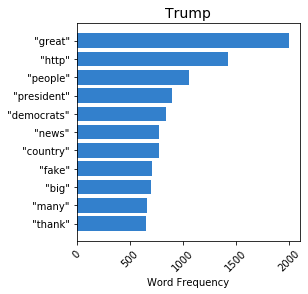

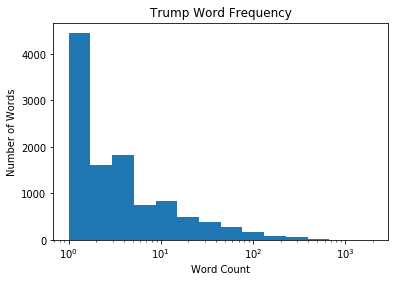

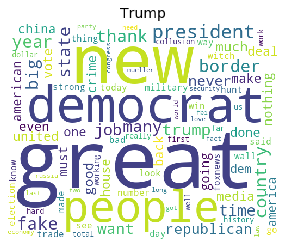

['"great"', '"http"', '"people"', '"president"', '"democrats"', '"news"', '"country"', '"fake"', '"big"', '"many"', '"thank"']


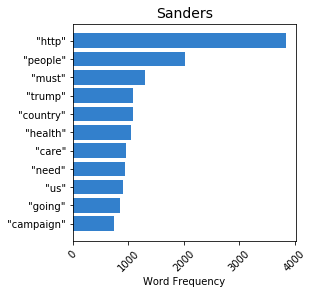

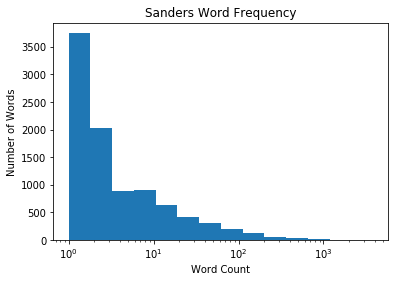

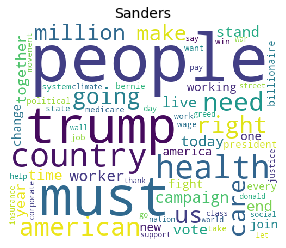

['"http"', '"people"', '"must"', '"trump"', '"country"', '"health"', '"care"', '"need"', '"us"', '"going"', '"campaign"']


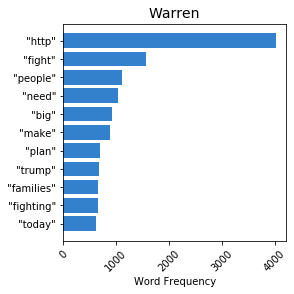

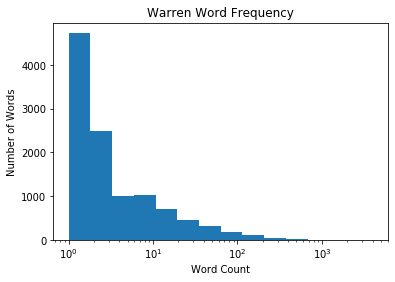

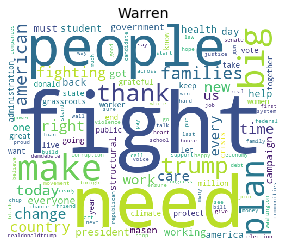

['"http"', '"fight"', '"people"', '"need"', '"big"', '"make"', '"plan"', '"trump"', '"families"', '"fighting"', '"today"']


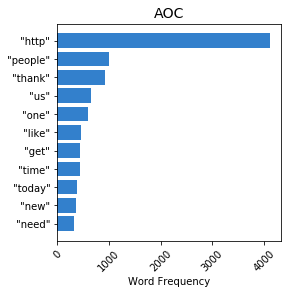

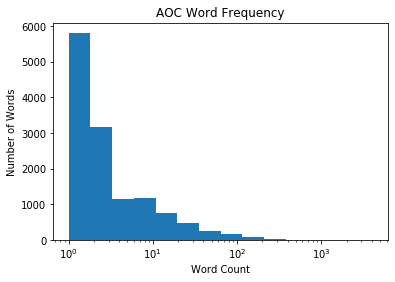

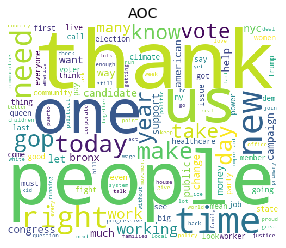

['"http"', '"people"', '"thank"', '"us"', '"one"', '"like"', '"get"', '"time"', '"today"', '"new"', '"need"']


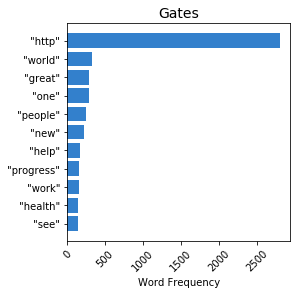

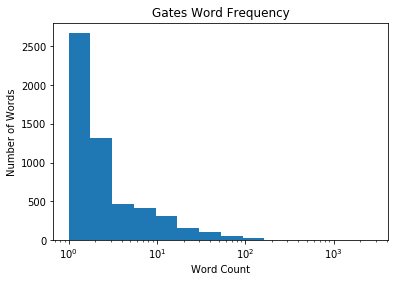

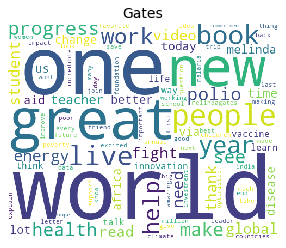

['"http"', '"world"', '"great"', '"one"', '"people"', '"new"', '"help"', '"progress"', '"work"', '"health"', '"see"']


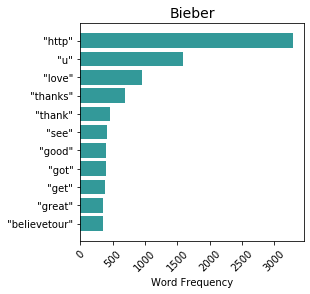

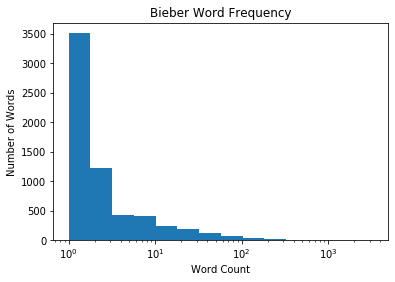

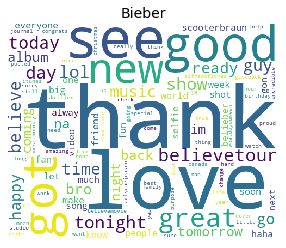

['"http"', '"u"', '"love"', '"thanks"', '"thank"', '"see"', '"good"', '"got"', '"get"', '"great"', '"believetour"']


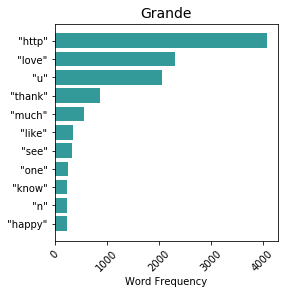

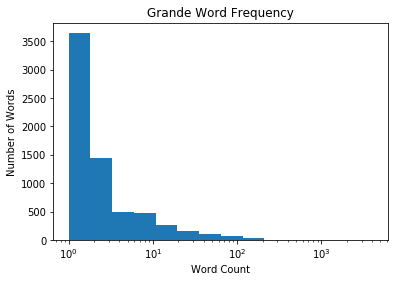

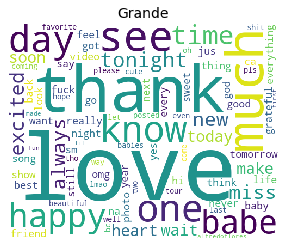

['"http"', '"love"', '"u"', '"thank"', '"much"', '"like"', '"see"', '"one"', '"know"', '"n"', '"happy"']


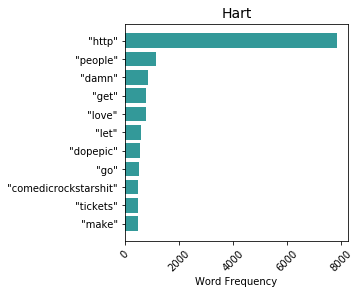

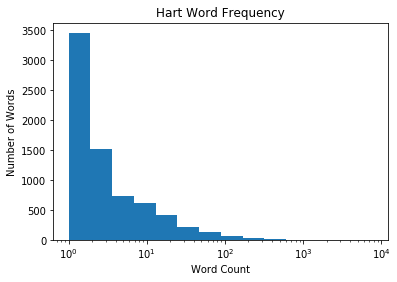

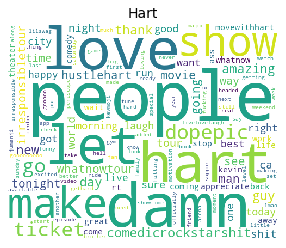

['"http"', '"people"', '"damn"', '"get"', '"love"', '"let"', '"dopepic"', '"go"', '"comedicrockstarshit"', '"tickets"', '"make"']


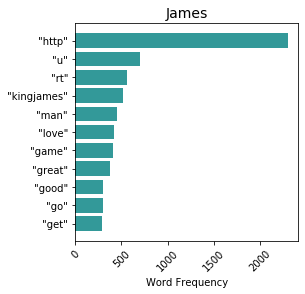

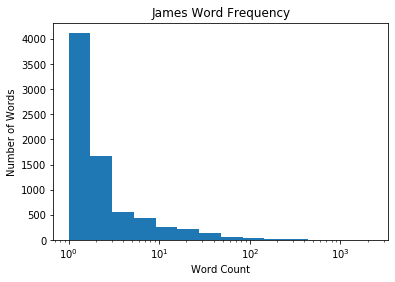

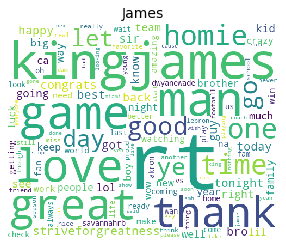

['"http"', '"u"', '"rt"', '"kingjames"', '"man"', '"love"', '"game"', '"great"', '"good"', '"go"', '"get"']


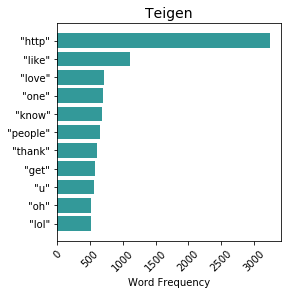

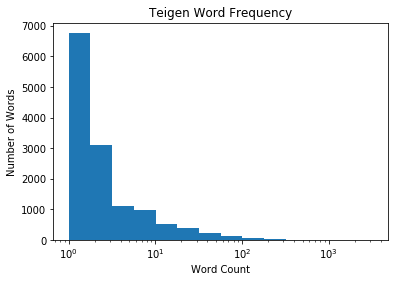

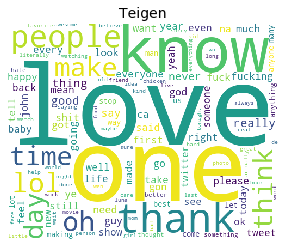

['"http"', '"like"', '"love"', '"one"', '"know"', '"people"', '"thank"', '"get"', '"u"', '"oh"', '"lol"']


In [10]:
# Word frequency

political = ['Trump','Sanders','Warren','AOC','Gates']
entertainers = ['Bieber','Grande','Hart','James','Teigen']
pol_wpt = []
ent_wpt = []
for person in political:
    pol_wpt.append(word_frequency(person,'csv',col1))
for person in entertainers:
    ent_wpt.append(word_frequency(person,'csv',col2))

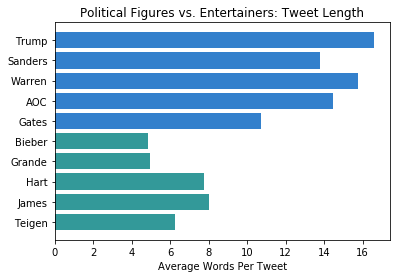

In [11]:
# Average words per tweet for training data
plt.barh(political+entertainers, pol_wpt+ent_wpt, color=[col1,col1,col1,col1,col1,col2,col2,col2,col2,col2])
plt.title('Political Figures vs. Entertainers: Tweet Length',fontsize=12)
plt.xlabel('Average Words Per Tweet')
plt.gca().invert_yaxis()
# plt.savefig('raw_wpt.png')
plt.show()

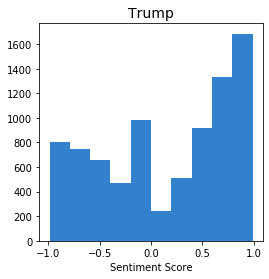

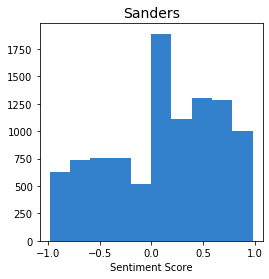

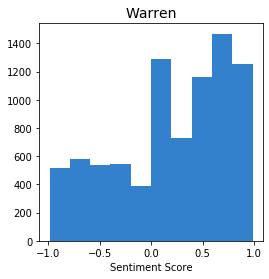

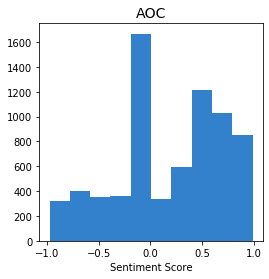

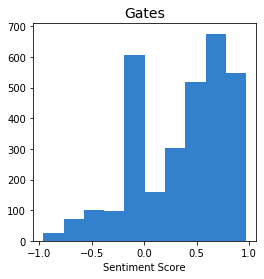

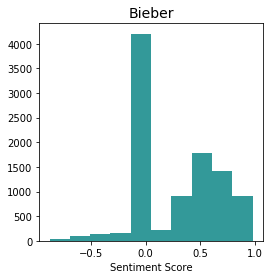

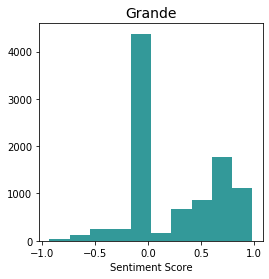

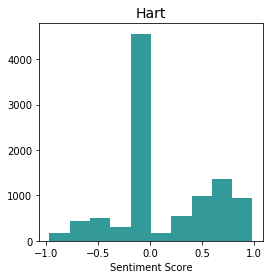

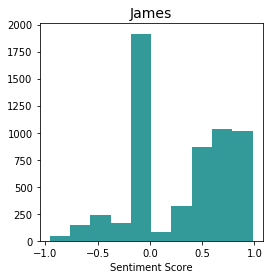

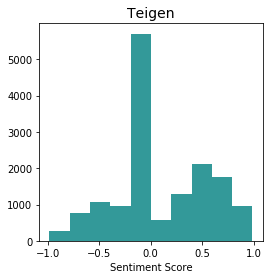

In [12]:
# Sentiment of training data

sid_obj = SentimentIntensityAnalyzer() 

pol_sent = []
ent_sent = []
all_sents = []

for person in political:
    sent,data = sentiment(person, sid_obj, col1)
    pol_sent.append(sent)
    all_sents.append(data)
for person in entertainers:
    sent,data = sentiment(person, sid_obj, col2)
    ent_sent.append(sent)
    all_sents.append(data)

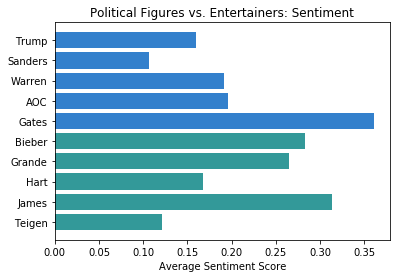

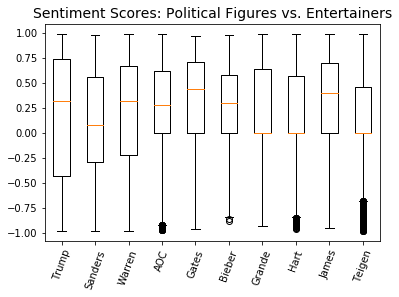

In [13]:
# Comparing sentiment of political and entertainers (training data)

plt.barh(political+entertainers, pol_sent+ent_sent, color=[col1,col1,col1,col1,col1,col2,col2,col2,col2,col2])
plt.title('Political Figures vs. Entertainers: Sentiment',fontsize=12)
plt.xlabel('Average Sentiment Score')
plt.gca().invert_yaxis()
# plt.savefig('raw_sent.png')
plt.show()

plt.boxplot(all_sents)
plt.title("Sentiment Scores: Political Figures vs. Entertainers", fontsize=14)
plt.xticks([1,2,3,4,5,6,7,8,9,10],political + entertainers, rotation=70)
# plt.savefig("sentiment_boxplot.png", bbox_inches = "tight")
plt.show()

# GPT-2 Generated Tweets Analysis

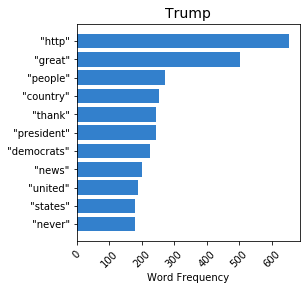

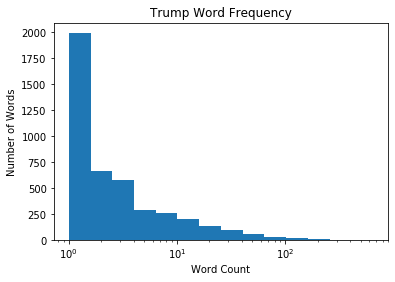

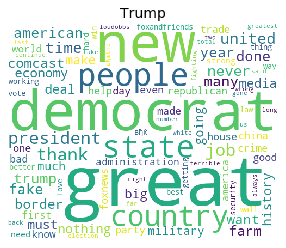

['"http"', '"great"', '"people"', '"country"', '"thank"', '"president"', '"democrats"', '"news"', '"united"', '"states"', '"never"']


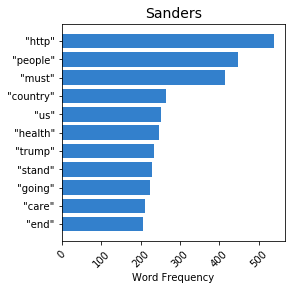

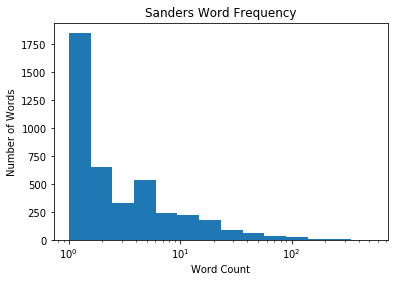

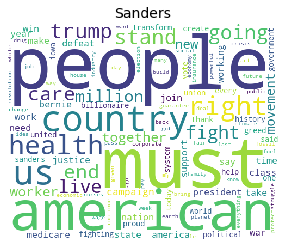

['"http"', '"people"', '"must"', '"country"', '"us"', '"health"', '"trump"', '"stand"', '"going"', '"care"', '"end"']


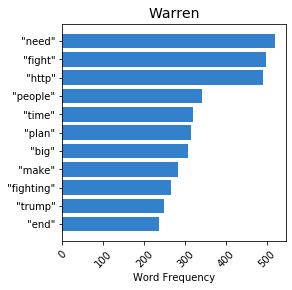

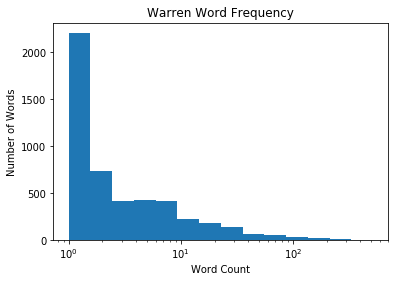

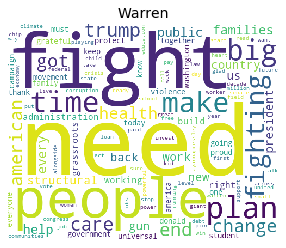

['"need"', '"fight"', '"http"', '"people"', '"time"', '"plan"', '"big"', '"make"', '"fighting"', '"trump"', '"end"']


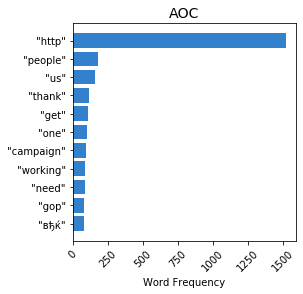

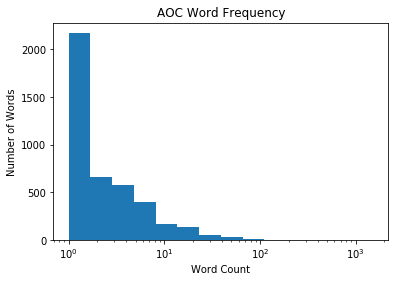

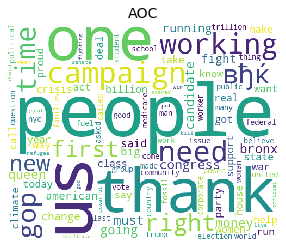

['"http"', '"people"', '"us"', '"thank"', '"get"', '"one"', '"campaign"', '"working"', '"need"', '"gop"', '"вђќ"']


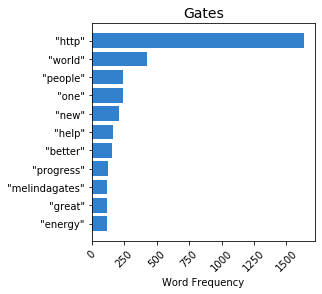

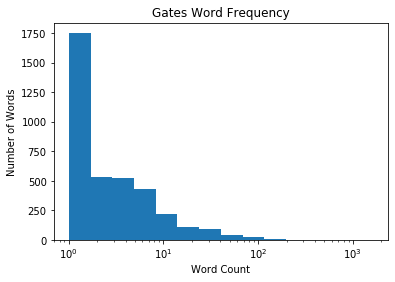

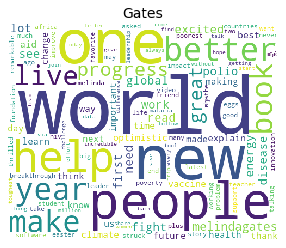

['"http"', '"world"', '"people"', '"one"', '"new"', '"help"', '"better"', '"progress"', '"melindagates"', '"great"', '"energy"']


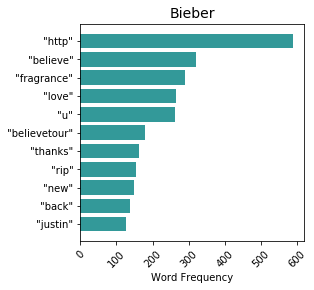

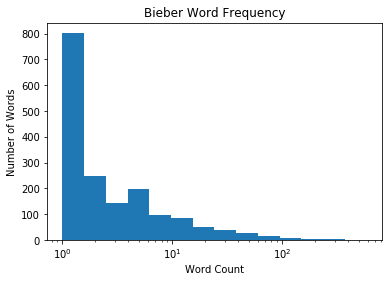

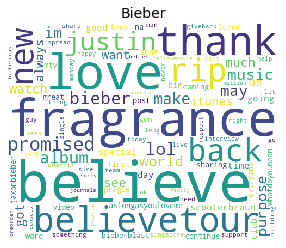

['"http"', '"believe"', '"fragrance"', '"love"', '"u"', '"believetour"', '"thanks"', '"rip"', '"new"', '"back"', '"justin"']


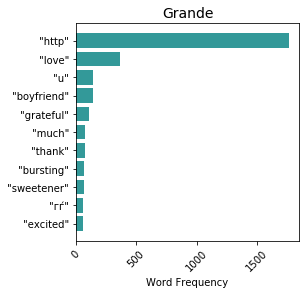

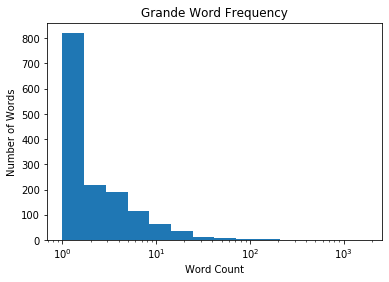

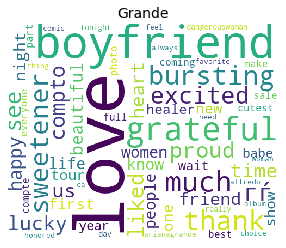

['"http"', '"love"', '"u"', '"boyfriend"', '"grateful"', '"much"', '"thank"', '"bursting"', '"sweetener"', '"гѓ"', '"excited"']


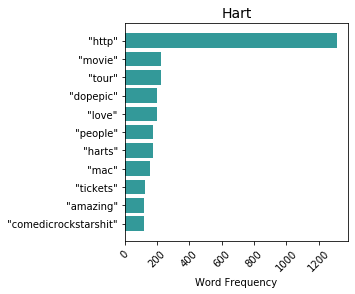

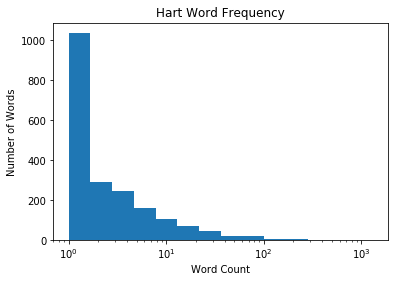

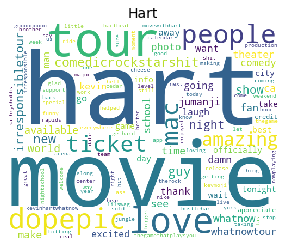

['"http"', '"movie"', '"tour"', '"dopepic"', '"love"', '"people"', '"harts"', '"mac"', '"tickets"', '"amazing"', '"comedicrockstarshit"']


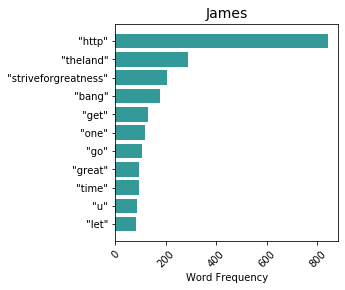

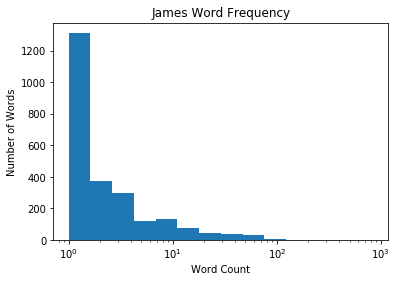

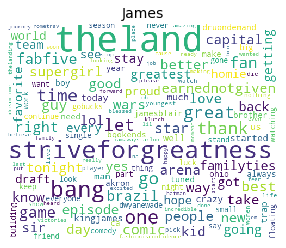

['"http"', '"theland"', '"striveforgreatness"', '"bang"', '"get"', '"one"', '"go"', '"great"', '"time"', '"u"', '"let"']


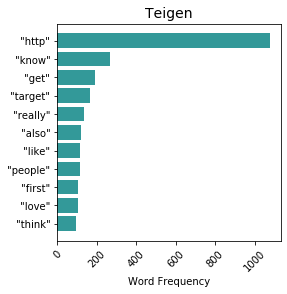

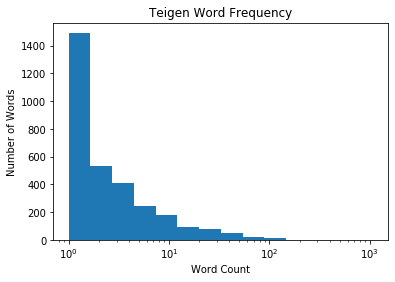

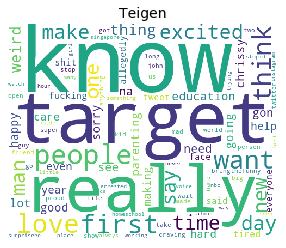

['"http"', '"know"', '"get"', '"target"', '"really"', '"also"', '"like"', '"people"', '"first"', '"love"', '"think"']


In [14]:
# Visualize word frequency

pol_generated = ['trump_gpt2_gentext_20200422_114633.txt',
                 'sanders_gpt2_gentext_20200422_132841.txt', 
                 'warren_gpt2_gentext_20200423_195923.txt',
                 'aoc_gpt2_gentext_20200424_103305.txt',
                 'gates_gpt2_gentext_20200422_144757.txt']
ent_generated = ['bieber_gpt2_gentext_20200422_143655.txt',
                 'grande_gpt2_gentext_20200423_172156.txt',
                 'hart_gpt2_gentext_20200423_145030.txt',
                 'james_gpt2_gentext_20200424_130853.txt',
                 'teigen_gpt2_gentext_20200424_125356.txt']
polg_wpt = []
entg_wpt = []
for g in pol_generated:
    polg_wpt.append(word_frequency(g,'gan_txt',col1))
for g in ent_generated:
    entg_wpt.append(word_frequency(g,'gan_txt',col2))

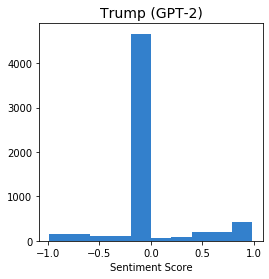

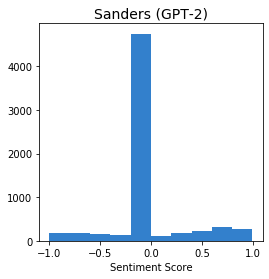

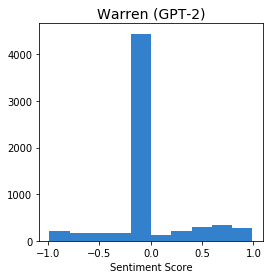

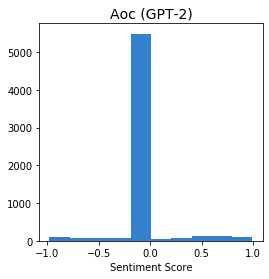

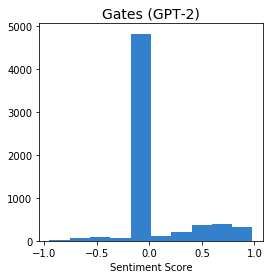

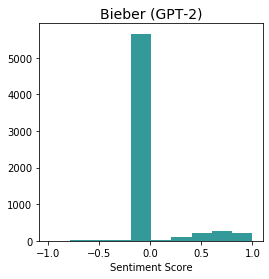

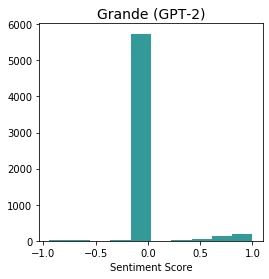

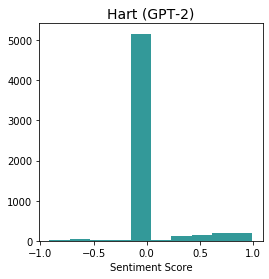

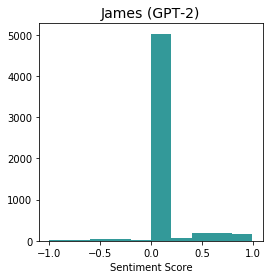

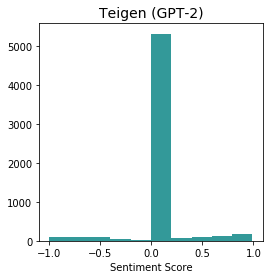

In [15]:
# Sentiment analysis

sid_obj = SentimentIntensityAnalyzer() 

pol_gsent = []
ent_gsent = []

for g in pol_generated:
    pol_gsent.append(sentiment_txt(g, 'gan',sid_obj, col1))
for g in ent_generated:
    ent_gsent.append(sentiment_txt(g, 'gan',sid_obj, col2))

# GPT-2 Generated Tweets vs. Actual Tweets (Training Data)

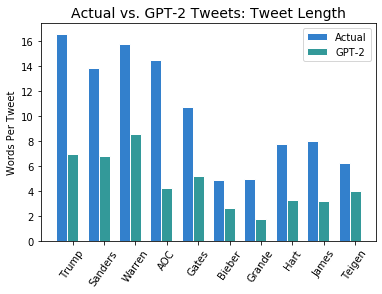

In [16]:
# Comparing words per tweet

barWidth = 0.35
bars1 = pol_wpt + ent_wpt
bars2 = polg_wpt + entg_wpt

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plt.bar(r2, bars2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')

plt.title('Actual vs. GPT-2 Tweets: Tweet Length', fontsize=14)
plt.xticks([r + barWidth for r in range(len(bars1))], political + entertainers, rotation=55)
plt.ylabel('Words Per Tweet')

plt.legend()
# plt.savefig('compared_wpt.png')
plt.show()

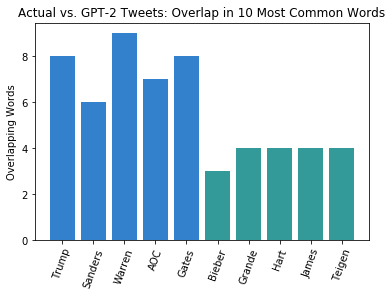

In [17]:
# Overlap in ten most frequently used words

matched_terms = [8,6,9,7,8,3,4,4,4,4]
plt.bar(political+entertainers, matched_terms, color=[col1,col1,col1,col1,col1,col2,col2,col2,col2,col2])
plt.title('Actual vs. GPT-2 Tweets: Overlap in 10 Most Common Words',fontsize=12)
plt.ylabel('Overlapping Words')
plt.xticks(rotation=70)
# plt.savefig('toptenmatch.png')
plt.show()

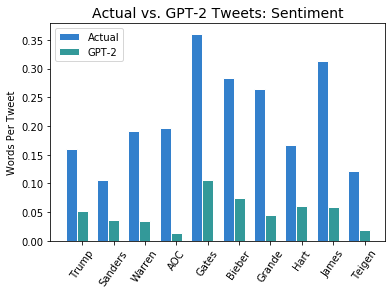

In [18]:
# Comparing sentiment

barWidth = 0.35
bars1 = pol_sent + ent_sent
bars2 = pol_gsent + ent_gsent

r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plt.bar(r2, bars2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')

plt.title('Actual vs. GPT-2 Tweets: Sentiment', fontsize=14)
plt.xticks([r + barWidth for r in range(len(bars1))], political + entertainers, rotation=55)
plt.ylabel('Words Per Tweet')

plt.legend()
# plt.savefig('compared_sent.png', bbox_inches = "tight")
plt.show()

# LSTM Generated Tweets Analysis

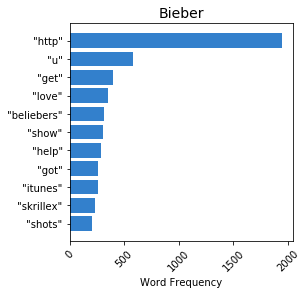

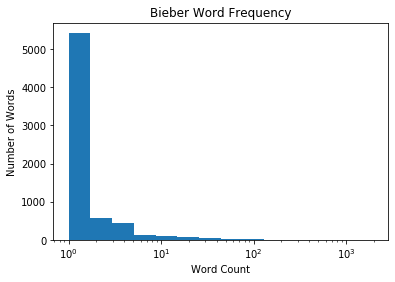

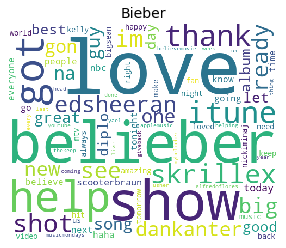

['"http"', '"u"', '"get"', '"love"', '"beliebers"', '"show"', '"help"', '"got"', '"itunes"', '"skrillex"', '"shots"']


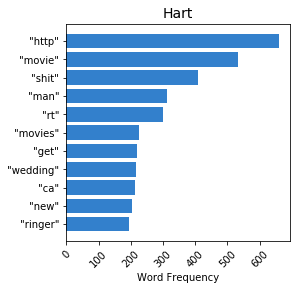

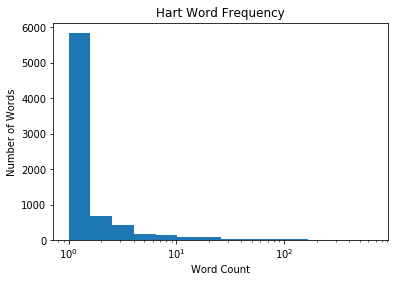

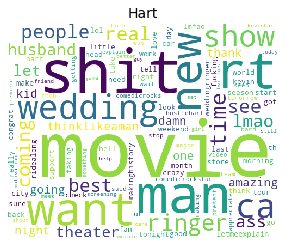

['"http"', '"movie"', '"shit"', '"man"', '"rt"', '"movies"', '"get"', '"wedding"', '"ca"', '"new"', '"ringer"']


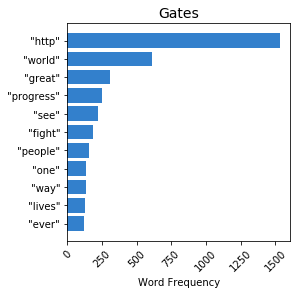

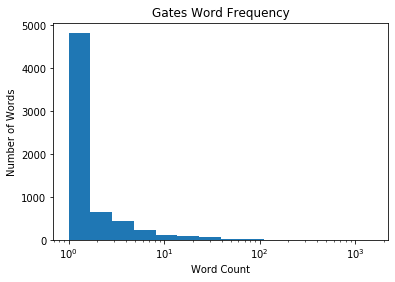

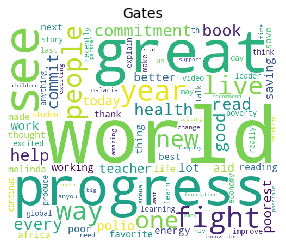

['"http"', '"world"', '"great"', '"progress"', '"see"', '"fight"', '"people"', '"one"', '"way"', '"lives"', '"ever"']


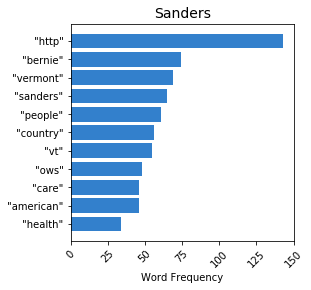

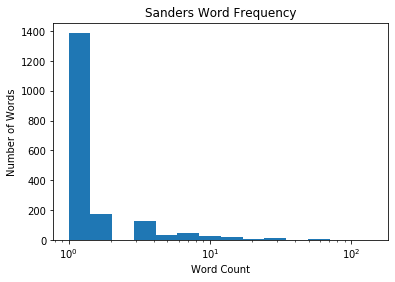

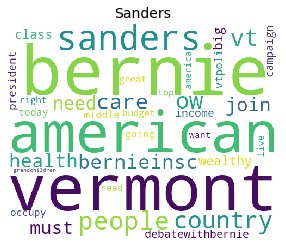

['"http"', '"bernie"', '"vermont"', '"sanders"', '"people"', '"country"', '"vt"', '"ows"', '"care"', '"american"', '"health"']


In [19]:
# Word frequency

lstm_people = ['bieber', 'hart', 'gates','sanders']

lstm_wpt = []
for g in lstm_people:
    lstm_wpt.append(word_frequency(g,'lstm_txt',col1))

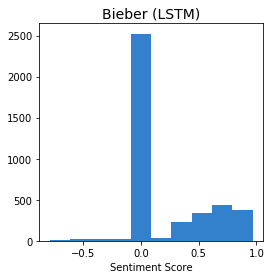

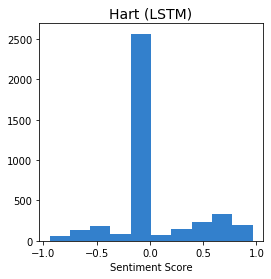

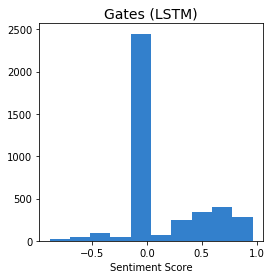

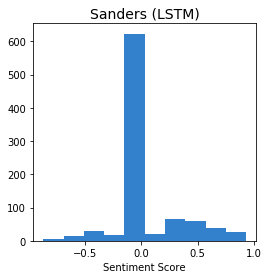

In [20]:
# Sentiment analysis

sid_obj = SentimentIntensityAnalyzer() 

lstm_sent = []

for g in lstm_people:
    lstm_sent.append(sentiment_txt(g, 'lstm',sid_obj, col1))

# GPT-2 vs. LSTM vs. Actual Tweets

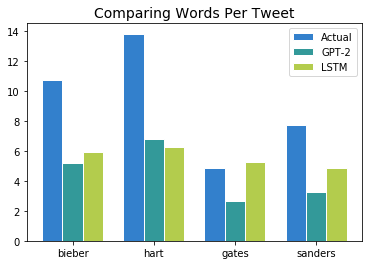

In [21]:
# Comparing words per tweet

barWidth = 0.25
b1 = [pol_wpt[4], pol_wpt[1], ent_wpt[0], ent_wpt[2]]
b2 = [polg_wpt[4], polg_wpt[1], entg_wpt[0], entg_wpt[2]]
b3 = lstm_wpt

r1 = np.arange(len(b1))
r2 = [x + barWidth for x in r1]
r3 =[x + barWidth for x in r2]

plt.bar(r1, b1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plt.bar(r2, b2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')
plt.bar(r3, b3, color=col3, width=barWidth, edgecolor='white', label='LSTM')

plt.title('Comparing Words Per Tweet', fontsize=14)
plt.xticks([r + barWidth for r in range(len(b1))], lstm_people)

plt.legend()
# plt.savefig('wpt_all.png')
plt.show()

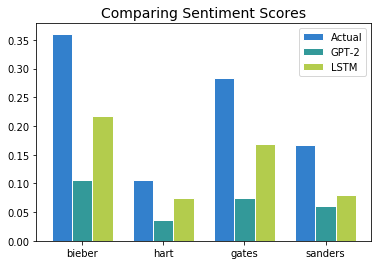

In [22]:
# Comparing sentiment

barWidth = 0.25
b1 = [pol_sent[4], pol_sent[1], ent_sent[0], ent_sent[2]]
b2 = [pol_gsent[4], pol_gsent[1], ent_gsent[0], ent_gsent[2]]
b3 = lstm_sent

r1 = np.arange(len(b1))
r2 = [x + barWidth for x in r1]
r3 =[x + barWidth for x in r2]

plt.bar(r1, b1, color=col1, width=barWidth, edgecolor='white', label='Actual')
plt.bar(r2, b2, color=col2, width=barWidth, edgecolor='white', label='GPT-2')
plt.bar(r3, b3, color=col3, width=barWidth, edgecolor='white', label='LSTM')

plt.title('Comparing Sentiment Scores', fontsize=14)
plt.xticks([r + barWidth for r in range(len(b1))], lstm_people)

plt.legend()
# plt.savefig('sentiment_all.png')
plt.show()